In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
import traci.constants as tc

In [2]:
sumoBinary = "/usr/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "osm.sumocfg"]

Códigos para cada uma das variáveis de subscribe:

In [3]:
SPEED = 64
POSITION = 66
ACCELERATION = 114
ANGLE = 67
DEPATURE = 58

Recebendo todas as variáveis para cada instante de execução e armazenando em all_variables:

In [4]:
def setSpeedMode(vehID, speedMode):
    # bit0: Regard safe speed
    # bit1: Regard maximum acceleration
    # bit2: Regard maximum deceleration
    # bit3: Regard right of way at intersections (only applies to approaching foe vehicles outside the intersection)
    # bit4: Brake hard to avoid passing a red light
    # bit5: Disregard right of way within intersections (only applies to foe vehicles that have entered the intersection)

    # CAUTION: 
    # bit5 has inverted semantics and must be set to '1' in order to disable the safety function. This achieves backward compatibility with earlier versions of SUMO where this bit was not defined and right of way within intersection could not be ignored explicitly.

    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeedMode(vehID, speedMode)

In [5]:
def setSpeed(vehID, speed):
    # Sets the speed of the vehicle to max(speed, MaxVehicleSpeed)
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeed(vehID, speed)

In [6]:
def slowDown(vehID, targetSpeed, duration):
    # Slows down the vehicle to targetSpeed over the next duration seconds
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.slowDown(vehID, targetSpeed, duration)

In [7]:
def get_all_variables(vehIDs, personIDs, useGui=False):
    if useGui:
        traci.start(["sumo-gui", "-c", "osm.sumocfg"])
    else:
        traci.start(["sumo", "-c", "osm.sumocfg"])
    v_variables = {}
    p_variables = {}
    time = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        for veh_id in traci.simulation.getDepartedIDList():
            if veh_id in vehIDs:
                traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_ANGLE])
        
        for person_id in traci.simulation.getDepartedPersonIDList():
            if person_id in personIDs:
                traci.person.subscribe(person_id, [tc.VAR_POSITION, tc.VAR_SPEED])

        v_variables[time] = traci.vehicle.getAllSubscriptionResults().copy()
        p_variables[time] = traci.person.getAllSubscriptionResults().copy()
        
        if time == 0:
            setSpeedMode("veh7", 0b10000) 

        if time == 50:
            traci.vehicle.setMaxSpeed("veh7", 20)
            setSpeed("veh7", 20)

        if time == 80:
            slowDown("veh7", 0, 20)
        
        time += 1
        traci.simulationStep()
        
    traci.close()
    return v_variables, p_variables

In [8]:
# Devolve o tempo de depareture e arrival de um veículo ou pessoa
def get_departure_arrival(variables, ID):
    departure = 0
    arrival = 0
    departed = False
    for x in range(len(variables)):
        if ID in variables[x] and variables[x][ID] and not departed:
            departed = True
            departure = x
        elif ID not in variables[x] and departed:
            arrival = x
            break

    return departure, arrival

Função para o plot das variáveis

In [9]:
def static_plots(variables, ID, isVehicle=True):
    # Plots speed, acceleration, angle and position of a vehicle
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID)
    time = np.arange(departure, arrival, 1.0)
    
    if isVehicle:
        fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(18, 5))

    if isVehicle:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0,0].plot(time, speed, label='Speed', color='b')
        ax[0,0].set_xlabel('Exec Time')
        ax[0,0].set_ylabel('Speed')
        ax[0,0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1,1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1,1].set_xlabel('X pos')
        ax[1,1].set_ylabel('Y pos')

        acc = [variables[x][ID][ACCELERATION] for x in range(len(variables)) if ID in variables[x]]
        ax[0,1].plot(time, acc, label='Acceleration', color='g')
        ax[0,1].set_xlabel('Exec Time')
        ax[0,1].set_ylabel('Acceleration')
        ax[0,1].legend()

        angle = [variables[x][ID][ANGLE] for x in range(len(variables)) if ID in variables[x]]
        ax[1,0].plot(time, angle, label='Angle', color='purple')
        ax[1,0].set_xlabel('Exec Time')
        ax[1,0].set_ylabel('Angle')

    else:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0].plot(time, speed, label='Speed', color='b')
        ax[0].set_xlabel('Exec Time')
        ax[0].set_ylabel('Speed')
        ax[0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1].set_xlabel('X pos')
        ax[1].set_ylabel('Y pos')   

    plt.show()

In [10]:
vehIDs = ["veh0", "veh1"]
personIDs = []

In [22]:
try:
    veh_variables, ped_variables = get_all_variables(vehIDs, personIDs, useGui=False)
except Exception as e:
    traci.close()
    print(f"An error occurred: {e}")

 Retrying in 1 seconds
***Starting server on port 54775 ***
Loading net-file from 'osm.net.xml.gz' ... done (2773ms).
Loading additional-files from 'park.add.xml' ... done (42ms).
Loading additional-files from 'pa_rerouter.xml' ... done (650ms).
Loading done.


Simulation version 1.21.0 started with time: 0.00.
Simulation ended at time: 6755.00.
Reason: TraCI requested termination.
Performance:
 Duration: 18.58s
 TraCI-Duration: 3.42s
 Real time factor: 363.543
 UPS: 6569.990851
 UPS-Persons: 11173.941123
Vehicles:
 Inserted: 282
 Running: 0
 Waiting: 0
Persons:
 Inserted: 89
 Running: 0
Statistics (avg of 217):
 RouteLength: 3158.29
 Speed: 9.56
 Duration: 338.36
 WaitingTime: 30.63
 TimeLoss: 117.75
Bike Statistics (avg of 65):
 RouteLength: 3612.96
 Speed: 4.88
 Duration: 748.49
 WaitingTime: 31.05
 TimeLoss: 90.28
Statistics (avg of 282):
 DepartDelay: 0.70
Pedestrian Statistics (avg of 89 walks):
 RouteLength: 2808.71
 Duration: 2332.84
 TimeLoss: 278.10
DijkstraRouter answered 10328 queries and explored 11.04 edges on average.
DijkstraRouter spent 0.06s answering queries (0.01ms on average).
DijkstraRouter answered 282 queries and explored 2858.06 edges on average.
DijkstraRouter spent 1.29s answering queries (4.58ms on average).


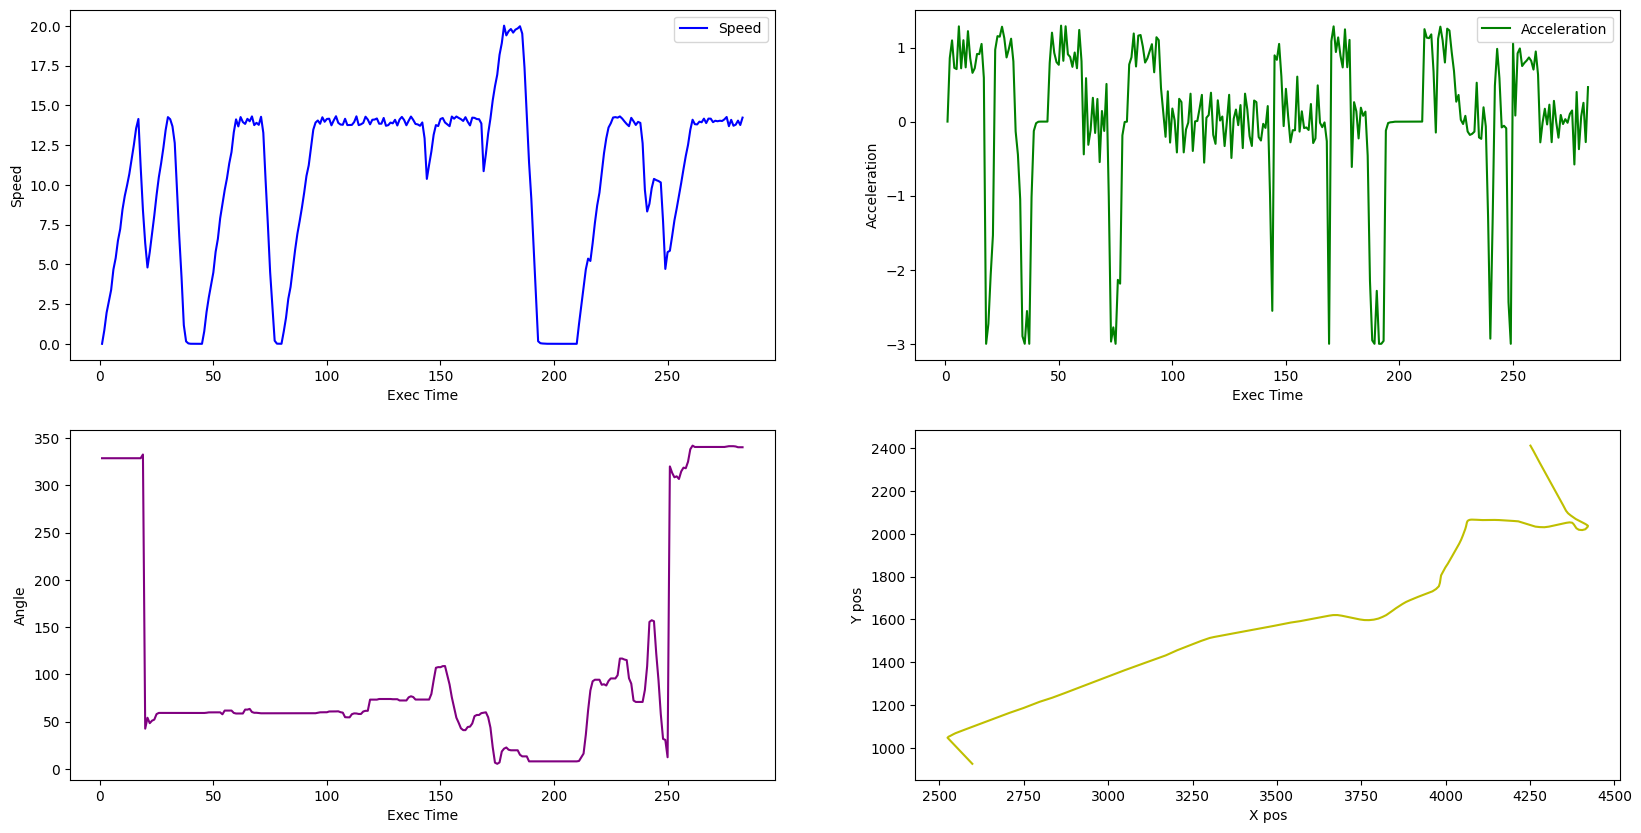

In [23]:
# Plot para o veículo 0
static_plots(veh_variables, "veh1", isVehicle=True)

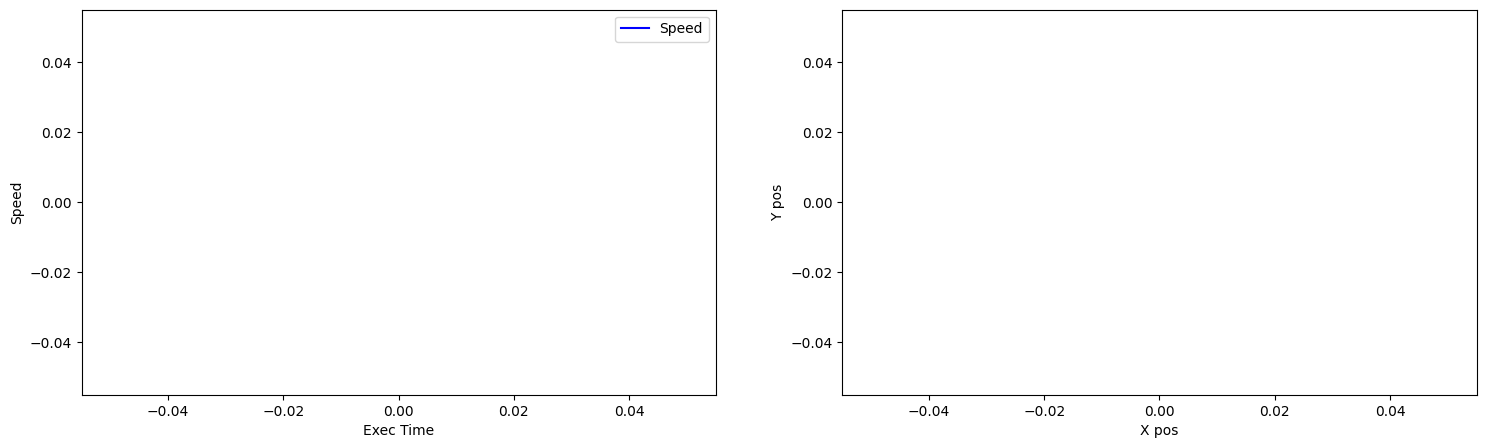

In [15]:
# Plot para o pedestre 0
static_plots(ped_variables, "ped1", False)

Criando gráfico dinâmico que roda juntamente com a simulação:

In [1]:
def dynamic_simulation_2(speed, acc, x, y, angle):
    %matplotlib
    plt.ion()
    fig, ax = plt.subplots(2, 2, figsize=(30, 20))
    ax[0,0].set_xlabel('Exec Time')
    ax[0,0].set_ylabel('Speed')
    
    for i in range(len(speed)):
        ax[0,0].clear()
        ax[0,0].plot(speed[:i], label='Speed', color='b')
        #ax[0,0].set_xlabel('Exec Time')
        #ax[0,0].set_ylabel('Speed')
        ax[0,0].legend()
            
        ax[0,1].clear()
        ax[0,1].plot(acc[:i], label='Acceleration', color='r')
        ax[0,1].set_xlabel('Exec Time')
        ax[0,1].set_ylabel('Acceleration')
        ax[0,1].legend()
        
        ax[1,0].clear()
        ax[1,0].plot(angle[:i], label='Angle', color='g')
        ax[1,0].set_xlabel('Exec Time')
        ax[1,0].set_ylabel('Angle')
        ax[1,0].legend()
        
        ax[1,1].clear()
        ax[1,1].plot(x[:i], y[:i], label='Position', color='y')
        ax[1,1].set_xlim(0, 1600)
        ax[1,1].set_ylim(0, 1900)
        ax[1,1].set_xlabel('X pos')
        ax[1,1].set_ylabel('Y pos')
        ax[1,1].legend()
            
        plt.draw()
        plt.pause(0.001)
        
    plt.ioff()
    plt.show()
    

In [2]:
speed = [i[vehID][SPEED] for i in all_variables[int(departure) + 1:]]
acc = [i[vehID][ACCELERATION] for i in all_variables[int(departure) + 1:]]
x = [i[vehID][POSITION][0] for i in all_variables[int(departure) + 1:]]
y = [i[vehID][POSITION][1] for i in all_variables[int(departure) + 1:]]
angle = [i[vehID][ANGLE] for i in all_variables[int(departure) + 1:]]

NameError: name 'all_variables' is not defined

In [3]:
dynamic_simulation_2(speed, acc, x, y, angle)

NameError: name 'speed' is not defined

In [9]:
def dynamic_simulation():
    %matplotlib
    plt.ion()
    fig, ax = plt.subplots(2, 2, figsize=(30, 20))
    all_variables = []
    speed = []
    acc = []
    x = []
    y = []
    angle = []
    traci.start(["sumo", "-c", "osm.sumocfg"])
    while traci.simulation.getMinExpectedNumber() > 0:
        for veh_id in traci.simulation.getDepartedIDList():
            traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_DEPARTURE, tc.VAR_ANGLE])
        variables = traci.vehicle.getAllSubscriptionResults()
        all_variables.append(variables.copy())
        time = np.arange(0, len(all_variables), 1.0)
        
        if variables:
            speed.append(variables[vehID][SPEED])
            acc.append(variables[vehID][ACCELERATION])
            x.append(variables[vehID][POSITION][0])
            y.append(variables[vehID][POSITION][1])
            angle.append(variables[vehID][ANGLE])
            ax[0,0].clear()
            ax[0,0].plot(time, speed, label='Speed', color='b')
            ax[0,0].set_xlabel('Exec Time')
            ax[0,0].set_ylabel('Speed')
            ax[0,0].legend()
            
            ax[0,1].clear()
            ax[0,1].plot(time, acc, label='Acceleration', color='r')
            ax[0,1].set_xlabel('Exec Time')
            ax[0,1].set_ylabel('Acceleration')
            ax[0,1].legend()

            ax[1,0].clear()
            ax[1,0].plot(time, angle, label='Angle', color='g')
            ax[1,0].set_xlabel('Exec Time')
            ax[1,0].set_ylabel('Angle')
            ax[1,0].legend()

            ax[1,1].clear()
            ax[1,1].plot(x, y, label='Position', color='y')
            ax[1,1].set_xlim(0, 1600)
            ax[1,1].set_ylim(0, 1900)
            ax[1,1].set_xlabel('X pos')
            ax[1,1].set_ylabel('Y pos')
            ax[1,1].legend()
            
            plt.draw()
            plt.pause(0.01)
        else:
            speed.append(0)
            acc.append(0)
            angle.append(0)

        traci.simulationStep()
    traci.close()
    plt.ioff()
    plt.show()